# Best practices for Green IT coding in python

In this tutorial, we will show good pratices for a green IT approach to code an image processing chain with efficiency in mind

# Good pratices for general python coding

## for loop optimisations : benefits of using numpy

using a for loop vs numpy for basic loop coding shows that you must avoid for loops in your code, here is a code snippet that shows the big performance difference to apply a square on 250 000 elements

In [19]:
import time
import numpy as np

start = time.perf_counter()
# Calculate square with for loop
array_forloop = []
for i in range(0,500):
    for j in range(0,500):
        array_forloop.append((i * j) ** 2)
    
end = time.perf_counter()
print("Time with for loop : {} ms".format((end-start)*1000))

# Using list comprehension instead of a for loop is a nice optimisation if your use case needs a for loop anyway
start = time.perf_counter()
array_forloop = [i**2 for i in range(0,250000)]
end = time.perf_counter()
print("Time with for list comprehension : {} ms".format((end-start)*1000))
      
# Using numpy
start = time.perf_counter()
arr = np.arange(250000)
squared_arr = np.square(arr)
end = time.perf_counter()
print("Time with numpy : {} ms".format((end-start)*1000))

Time with for loop : 83.00238009542227 ms
Time with for list comprehension : 63.063559122383595 ms
Time with numpy : 0.2981601282954216 ms


## Searching informations in your data

If your code needs to search elements in an image for example looking at NoData pixels, it is highly recommended to do that search in a set instead of a list of pixels :

In [29]:
from timeit import timeit
import numpy as np

nd_list = [i for i in range(0,100000)]
nd_set = set([i for i in range(0,100000)])
nd_array = np.arange(0,100000)

#Look at an element
def search_list():
    if 98950 in nd_list:
        pass
    
#Look at the same element in the set
def search_set():
    if 98950 in nd_set:
        pass

def search_numpy():
    if np.where(nd_array==98950):
        pass

#lets say nodata value is 98950 in that case
t1 = timeit(search_list, number=100000)
t2 = timeit(search_set, number=100000)
t3 = timeit(search_numpy, number=100000)
print("List search time: {} s".format(t1))
print("Set search time: {} s".format(t2))
print("Numpy search time: {} s".format(t3))

List search time: 42.939479635097086 s
Set search time: 0.006291795987635851 s
Numpy search time: 4.1151342540979385 s


## Conclusion

* Don't try to reinvent the wheel, use standard and well performing python libraries like numpy
* Avoid using for loops to apply a computing on a bunch of pixels, use numpy instead
* If you need a for loop for another processing, use list comprehension as much as possible, it is very well documented 
* Use sets when you need to lookup for values in your image but beware that the set is not intended to be modified. You can alternatively use numpy.where but it is not as efficient as the set because it returns a boolean array for each element of the array, nevertheless it is 10 times more efficient than a list.

For an in-depth comparison of how much numpy is faster than for and while loops, this link provides a complete performance comparison : https://www.blog.duomly.com/loops-in-python-comparison-and-performance/

# Profiling your processing chain with TREX monitoring

In order to optimize your chain, you have to check where are the bottleneck of your program. The TREX cluster provides all the tools you need for that, with the monitoring module.

In this tutorial, we use this script to execute as a slurm job, which creates the graphs for CPU, RAM, DISK in png format

The in depth documentation is available [here](https://hpc.pages.cnes.fr/wiki-hpc-sphinx/module-monitoring-2.html)

In [ ]:
greenit_slurm_script_monitored = """#!/bin/bash
#
# Load monitoring module
module load monitoring/2.2
#
# Use of SLURM $TMPDIR  of the interactive job
WORKDIR=$TMPDIR
SLURM_SUBMIT_DIR=/work/scratch/env/romaint/greenit/perfos_greenit
#
cd "$WORKDIR"
#
# Give model name
#
MODEL_NAME=test_perfo_greenit
#
# launch start_monitoring.sh to start monitoring of the job ( --name option mandatory)
#
start_monitoring.sh --name $MODEL_NAME --io local
#
# lauch program
#
source /work/scratch/env/romaint/greenit/env_greenit_py312/bin/activate
python3 /work/scratch/env/romaint/greenit/test_parallelisation.py
#
# Stop monitoring -it will generate output_monitoring directory
#
stop_monitoring.sh --name $MODEL_NAME

"""

# A Green IT approach for coding image processing chains

In this notebook we will look at a green IT approach of coding, via good pratices in Python. We will have a look at Dask, RioXarray, rasterio, numpy... all these libraries that are widely used in the satellite image processing chains. 

## Necessary imports for the notebook

In [5]:
import numpy as np
import rasterio
import xarray
import rioxarray as rxr
from numba import jit,njit
from xarray import DataArray 
from pathlib import Path
from typing import List, Tuple, Union, Dict
from dask import delayed
from dask.distributed import Client, LocalCluster, Lock
import dask.array as da
from rasterio.transform import Affine
import time

## Work directories for the notebook

In [6]:
data_dir = "/work/scratch/data/romaint"
s2_b4 = f"{data_dir}/input_greenit/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1_FRE_B4.tif"
s2_b8 = f"{data_dir}/input_greenit/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1_FRE_B8.tif"
phr_product_cog = f"{data_dir}/input_greenit/phr_cog.tif"
phr_product_lzw = f"{data_dir}/input_greenit/phr_lzw.tif"

## Defining usefull functions for our notebook

In [3]:
def open_raster_and_get_metadata(raster_paths: List[str], chunks: Union[int, Tuple, Dict, None], lock: Union[int,None]):
    """
    Opens multiple raster files, extracts shared geospatial metadata, 
    and returns the concatenated data along with resolution and CRS info.

    Parameters:
    -----------
    raster_paths : List[str]
        Paths to the raster files.
    chunks : Union[int, Tuple, Dict, bool, None]
        Chunk sizes for Dask (bands, height, width).

    Returns:
    --------
    Tuple[dask.array.Array, float, float, float, float, Union[str, CRS]]
        Concatenated raster data, x and y resolution, top-left coordinates, and CRS.
    """
    results = []
    for raster_path in raster_paths:
        with rxr.open_rasterio(raster_path, chunks=chunks, lock=lock) as tif:
            reprojection = tif
            transform = reprojection.rio.transform()
            crs = reprojection.rio.crs
            x_res = transform[0]
            y_res = -transform[4]
            top_left_x = transform[2]
            top_left_y = transform[5]
            results.append(reprojection)

    return da.concatenate(results), x_res, y_res, top_left_x, top_left_y, crs

def create_raster(data: np.ndarray, output_file: Path, x_res, y_res, top_left_x, top_left_y, crs):
    transform = Affine.translation(top_left_x, top_left_y) * Affine.scale(x_res, -y_res)
    with rasterio.open(
            output_file, "w",
            driver="GTiff",
            height=data.shape[1],
            width=data.shape[2],
            count=data.shape[0],
            dtype=data.dtype,
            crs=crs,
            transform=transform
    ) as dst:
        dst.write(data)

## Creating the Dask Cluster

In order to use dask we first need to create a [LocalCluster](https://docs.dask.org/en/stable/deploying-python.html#localcluster) which allow us to create workers and use [dask's dashboard](https://docs.dask.org/en/latest/dashboard.html).


In [2]:
cluster = LocalCluster()
client = Client(cluster)

print("Dask Dashboard: ", client.dashboard_link)
client

Dask Dashboard:  http://127.0.0.1:8787/status


<Client: 'tcp://127.0.0.1:40559' processes=4 threads=4, memory=28.00 GiB>

Dask return an url where the dashboard is availaible (usually http://127.0.0.1:8787/status). This is not a tutorial on how to use this dashboard, but we recommend using it in a separate window while using this notebook.

# Use Case : Calculation of the Average NDVI on a Sentinel 2 image

In this example, we will use standard python libraries to: 

1. Read the data from the disk and stack them.
2. Calculate the associated NDVI, which combines multi-band information into a single band.
4. Write the resulting image to the disk.

First, let's read the data we need to perform the NDVI with RIOXarray.

### Open raster thanks to rioxarray

Here we are going to open the raster data required for this tutorial, the RGB bands from a Sentinel-2 acquisition. To do this, we're going to use rioxarray and, more specifically, the [open_rasterio](https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray-open-rasterio) method, which opens the images lazily (without loading data into memory) and returns a `dask.array` object. 
From this method we will use the ``chunks`` and ``lock`` arguments, which respectively set a chunk size and limit access to the data to one thread at a time to avoid read problems. Here ``chunks`` is set to ``True`` to allow dask to automatically size chunks.

When the data is read, we can express the NDVI calculation as if it were a numpy array. We add ``[None, :, :]`` to keep the shape as ``(bands, rows, cols)``. Then we can apply reduction on the dask.array and use ``compute()`` on it to triger the computation.

In [7]:
# Open the raster
reading_chunks = (-1,2200,2200)
input_data_array, x_res, y_res, top_left_x, top_left_y, crs = open_raster_and_get_metadata([s2_b4,s2_b8], reading_chunks, False)
input_data_array

dask.array<concatenate, shape=(2, 10980, 10980), dtype=int16, chunksize=(1, 2200, 2200), chunktype=numpy.ndarray>

In [8]:
%%time

ndvi_array = (input_data_array[1] - input_data_array[0]) / (input_data_array[1] + input_data_array[0])[None, :, :]
# Launch the computing with dask with the compute call
mean_ndvi = ndvi_array.compute() 
crs="EPSG:4326"
output_file = Path(f"{data_dir}/output_greenit/ndvi_dask.tif")
create_raster(mean_ndvi, output_file, x_res , y_res,
                  top_left_x, top_left_y, crs)

CPU times: user 454 ms, sys: 1.26 s, total: 1.72 s
Wall time: 3.9 s


## Calculate NDVI With OTB in python

In [1]:
import otbApplication as otb

out_ndvi_otb_py="/work/scratch/data/romaint/output_greenit/img_ndvi_otb_py.tif"
#Compute NDVI with OTB in python
app_ndvi_otb = otb.Registry.CreateApplication("BandMath")
app_ndvi_otb.SetParameterStringList("il",[s2_b4,s2_b8])
app_ndvi_otb.SetParameterString("exp","(im2b1-im1b1)/(im2b1+im1b1)")
#app_ndvi_otb.SetParameterStringList("il",[phr_product_cog])
#app_ndvi_otb.SetParameterString("exp","(im1b4-im1b1)/(im1b4+im1b1)")
app_ndvi_otb.SetParameterString("out",out_ndvi_otb_py)
app_ndvi_otb.SetParameterInt("ram",2048)
app_ndvi_otb.ExecuteAndWriteOutput()

ModuleNotFoundError: No module named 'otbApplication'

## Calculate NDVI with OTB in C++
This part will call BandMath with the otb CLI to compare performances with the python swig interface

In [7]:
%%bash

WORK_DIR="/work/scratch/data/romaint"
otbcli_BandMath -il "${WORK_DIR}/input_greenit/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1_FRE_B4.tif" "${WORK_DIR}/input_greenit/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1_FRE_B8.tif" -exp "( im2b1 - im1b1 ) / ( im2b1 + im1b1 )" -out "${WORK_DIR}/output_greenit/img_ndvi_otb_cpp.tif" 

Warning 1: Invalid value for NUM_THREADS: 


Writing /work/scratch/data/romaint/output_greenit/img_ndvi_otb_cpp.tif...: 100% [**************************************************] (2s)


## Conclusion

The compute time with OTB for a simple NDVI computing is lower than standard python computing, this is mainly due to the overkill usage of dask with single band files.
Now let's see how to optimize our initial code, to determine when it using dask becomes important

# Compute time optimisation methods for NDVI

Let's see if we can improve the computing time with well known python libraries, with a Sentinel 2 product (size of about 2 Go if you include the bands you need only), every file is single band

In [41]:
%%time

@njit
def one_pixel_ndvi(p1,p2):
    return (p2-p1) / (p2+p1) 

@njit
def compute_ndvi_numba(input_data_1: np.ndarray,input_data_2: np.ndarray):
    #ndvi_array = [one_pixel_ndvi(i,j) for i in input_data_1 for j in input_data_2]
    ndvi_array = (input_data_2 - input_data_1) / (input_data_2 + input_data_1)
    return ndvi_array

def compute_ndvi_dask(input_data_1: DataArray,input_data_2: DataArray):
    ndvi_array = ((input_data_2 - input_data_1) / (input_data_2 + input_data_1))[None,:,:]
    ndvi_array.compute()
    return ndvi_array

def compute_ndvi_std(input_data_1: np.ndarray,input_data_2: np.ndarray):
    #ndvi_array = [one_pixel_ndvi(i,j) for i in input_data_1 for j in input_data_2]
    ndvi_array = (input_data_2 - input_data_1) / (input_data_2 + input_data_1)
    return ndvi_array

start = time.perf_counter()
with rasterio.open(s2_b4, 'r') as ds:
    input_data_b4 = ds.read() 

with rasterio.open(s2_b8, 'r') as ds:
    input_data_b8 = ds.read()
   
ndvi_computed = compute_ndvi_numba(input_data_b4,input_data_b8)
crs="EPSG:4326"
output_file = Path(f"{data_dir}/output_greenit/ndvi_numba.tif")
create_raster(ndvi_computed, output_file, x_res , y_res, top_left_x, top_left_y, crs)
end = time.perf_counter()
print("Elapsed with Raster IO + numba = {}s".format((end - start)))

start = time.perf_counter()
with rasterio.open(s2_b4, 'r') as ds:
    input_data_b4 = ds.read() 

with rasterio.open(s2_b8, 'r') as ds:
    input_data_b8 = ds.read()

ndvi_computed = compute_ndvi_std(input_data_b4,input_data_b8)
crs="EPSG:4326"
output_file = Path(f"{data_dir}/output_greenit/ndvi_without_numba.tif")
create_raster(ndvi_computed, output_file, x_res , y_res,top_left_x, top_left_y, crs)
end = time.perf_counter()
print("Elapsed with Raster IO + without numba = {}s".format((end - start)))
# Example with xarray
start = time.perf_counter()
input_data_b4 =  xarray.open_dataarray(s2_b4)
input_data_b8 =  xarray.open_dataarray(s2_b8)
ndvi_computed = xarray.apply_ufunc(compute_ndvi_std,input_data_b4,input_data_b8)
output_file = Path(f"{data_dir}/output_greenit/ndvi_ufunc.tif")
ndvi_computed.rio.to_raster(output_file)
end = time.perf_counter()
print("Elapsed with Xarray + apply ufunc = {}s".format((end - start)))

start = time.perf_counter()
input_data, x_res, y_res, top_left_x, top_left_y, crs = open_raster_and_get_metadata([s2_b4,s2_b8], (-1,2200,2200), False)
ndvi_array = compute_ndvi_dask(input_data[0],input_data[1])
output_file = Path(f"{data_dir}/output_greenit/ndvi_dask.tif")
create_raster(ndvi_array, output_file, x_res , y_res, top_left_x, top_left_y, crs)
end = time.perf_counter()
print("Elapsed with RIOXarray + dask = {}s".format((end - start)))


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


Elapsed with Raster IO + numba = 1.6279641180299222s
Elapsed with Raster IO + without numba = 1.7432440733537078s
Elapsed with Xarray + apply ufunc = 3.0273265461437404s
Elapsed with RIOXarray + dask = 4.102793791797012s
CPU times: user 2.25 s, sys: 5.03 s, total: 7.28 s
Wall time: 10.5 s


## Conclusion for a Sentinel 2 product with single band files (~3Go for the full product)

* Using **RIOXarray + dask on single band product is counter productive**.
* Xarray + applyufunc also leads to low performance compared to opening the whole product with rasterio.
* Using numba do enhances the performance but with less than 10%, it is more suitable for numpy vectorize [optimisation]( https://numba.readthedocs.io/en/stable/user/vectorize.html#the-vectorize-decorator)


# The importance of reducing the size of your data

Let's see how the size of your data can have an impact on your compute time

## Simple LZW Compression with RasterIO

In [ ]:
# Register GDAL format drivers and configuration options with a
# context manager.
with rasterio.Env():

    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = raster.profile

    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
    profile.update(compress='lzw')

    with rasterio.open(os.environ['TMPDIR'] + '/lzw.tif', 'w', **profile) as dst:
        dst.write(raster.read(1), 1)

## Create a CoG without overview

In [ ]:
with rasterio.Env():
    profile = raster.profile
    profile.update(tiled=True, compress='lzw', blockxsize=512, blockysize=512)
    with rasterio.open(os.environ['TMPDIR'] + '/cog.tif', 'w', **profile) as dst:
        dst.write(raster.read(1), 1)

In [2]:
!du -sh $TMPDIR/*

^C


### Size gain after compression

Initial PLEIADES product size : 13 Go

#### LZW
Product size : 10 Go

#### CoG
Product size : 7 Go

### Compute time with compressed files

In [ ]:
reading_chunks = (-1,2048,2048)
start=time.perf_counter()
data_array = rxr.open_rasterio(phr_product_lzw, chunks=reading_chunks, lock=False)
ndvi_array = (data_array[3] - data_array[0]) / (data_array[3] + data_array[0])
output_file = Path(f"{data_dir}/output_greenit/ndvi_lzw.tif")
ndvi_array.rio.to_raster(output_file)
end=time.perf_counter()
print("Elapsed with LZW compressed file = {}s".format((end - start)))

start=time.perf_counter()
data_array = rxr.open_rasterio(phr_product_cog, chunks=reading_chunks, lock=False)
ndvi_array = (data_array[3] - data_array[0]) / (data_array[3] + data_array[0])
output_file = Path(f"{data_dir}/output_greenit/ndvi_cog.tif")
ndvi_array.rio.to_raster(output_file)
end=time.perf_counter()
print("Elapsed with CoG compressed file = {}s".format((end - start)))

## Conclusion

* Using LZW or CoG does reduce the size of your data on disk and reduce the computing time, but **beware than in memory the product size will still be the original product's size**

* Using CoG is more efficient in disk size and computational time (see the next chapter)


## The size of your image should lead you to use the right library

**If your product is single band or its size is less than your RAM size divided by the number of CPUs (not threads), it is not recommended to use parallelisation libraries such as dask**

Let's say you have an average computer that has 16 or 32Go RAM : with this amount of ram we recommend using dask if your **product size is > 3 Go**

**If your product is multi-band, use RIOXarray or Dask, we will see in the next chapter that you can tune the parameters to improve the read/write performances**

Let's see a use case where parralellisation methods are worth it

# Use case : I have to use multiple products which average size is > 10Go

In this example we will use a PLEIADES product (which original size is 13Go) in CoG format which size is 7 Go

This is the typical use case where dask or rioxarray with parallel read and write support is necessary to speedup your processing. Let's see what are the recommended parameters to optimize your processing with big data

## Optimize dask parameters

### Find the right chunk size for dask

Chunk size is becoming very important when your data size grows. You can let chunks=True to dask which will automatically determine a chunk size
Most of the time this chunk size is coherent but users can tweak it to be more efficient.

Also be careful about the compute() method, which is not recommended when your data size => 10Go, the memory consumption increases a lot

In [5]:
# First example letting dask compute the chunks
reading_chunks = True
data_array_autochunks = rxr.open_rasterio(phr_product_cog, chunks=reading_chunks,lock=False)
data_array_autochunks

<xarray.DataArray (band: 4, y: 41663, x: 39844)> Size: 13GB
dask.array<open_rasterio-fc2e18048eec7fd8788f8fc93c7ebea6<this-array>, shape=(4, 41663, 39844), dtype=uint16, chunksize=(1, 8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 319kB 0.5 1.5 2.5 ... 3.984e+04 3.984e+04 3.984e+04
  * y            (y) float64 333kB 0.5 1.5 2.5 ... 4.166e+04 4.166e+04 4.166e+04
    spatial_ref  int64 8B 0
Attributes: (12/29)
    AcquisitionDate:      2023-04-15T11:00:24.3Z
    BlueDisplayChannel:   0
    DataType:             3
    GeometricLevel:       SENSOR
    GreenDisplayChannel:  0
    ImageID:              6967638101-1
    ...                   ...
    TimeRangeEnd:         2023-04-15T11:00:27.3815980Z
    TimeRangeStart:       2023-04-15T11:00:24.3193675Z
    NoData:               0
    _FillValue:           0
    scale_factor:         1.0
    add_offset:           0.0

In [6]:
start=time.perf_counter()
ndvi_array = (data_array_autochunks[3] - data_array_autochunks[0]) / (data_array_autochunks[3] + data_array_autochunks[0])
output_file = Path(f"{data_dir}/output_greenit/ndvi_autochunks.tif")
ndvi_array.rio.to_raster(output_file)
end=time.perf_counter()
print("Elapsed with automatic chunk size = {}s".format((end - start)))

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/usr/local/lib/python3.10/dist-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/usr/local/lib/python3.10/dist-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/usr/local/lib/python3.10/dist-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/usr/local/lib/python3.10/dist-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


Elapsed with automatic chunk size = 75.2928059049882s


In [3]:
ndvi_array

NameError: name 'ndvi_array' is not defined

In [7]:
start=time.perf_counter()
reading_chunks = (-1,2048,2048)
data_array_manualchunks = rxr.open_rasterio(phr_product_cog, chunks=reading_chunks, lock=False)
ndvi_array = (data_array_manualchunks[3] - data_array_manualchunks[0]) / (data_array_manualchunks[3] + data_array_manualchunks[0])
output_file = Path(f"{data_dir}/output_greenit/ndvi_manualchunks.tif")
ndvi_array.rio.to_raster(output_file)
end=time.perf_counter()
print("Elapsed with manual chunk size = {}s".format((end - start)))

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


Elapsed with manual chunk size = 100.88597717694938s


In [3]:
ndvi_array

NameError: name 'ndvi_array' is not defined

### Conclusion

Prefer using rxr.to_raster() instead of dask.compute() when your product size is getting bigger as the later seems to be more CPU consuming

#### Chunk size recommandation for multi band products

When using multiple band products, dask will take chunks per band, which slows done the processing in case of a processing using more than one band. We recommand in that case defining chunks using "(-1,sizex,sizey)" which creates chunks with concatenated bands. The time gain can be up to 20% !

#### Don't hesitate to test different chunk sizes before making a conclusion

In our case we used chunks of 32Mo, it is a best practice to use chunks size multiple of 8 for read/write efficiency in RAM.

#### Adjust the number of workers for dask

If you have a lot of CPU, you can also gain time by adjusting the number of workers for dask, here for 8 CPU we used 4 workers, which gives 2 threads per CPU which is the perfect scenario for modern CPUs with hyperthreading (8 Core => 16 Threads)

## Improve disk write speed with rio.to_raster 

In the previous computing, we didn't use the tiled write capability of rio.to_raster, which speeds up the image writing on disk.
Let's see how to use it

In [20]:
%%time

start = time.perf_counter()
reading_chunks = (-1,2048,2048)
input_data_array = rxr.open_rasterio(phr_product_cog,chunks=reading_chunks,lock=False)
ndvi_phr = (input_data_array[3] - input_data_array[0]) / (input_data_array[3] + input_data_array[0])
ndvi_phr.compute()
output_file = Path(f"{data_dir}/output_greenit/ndvi_phr.tif")
ndvi_phr.rio.to_raster(output_file)
end = time.perf_counter()
print("Elapsed with RIOXarray + dask compute + product > 5Go = {}s".format((end - start)))

(4, 41663, 39844)


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


Elapsed with RasterIO + dask + product > 5Go = 71.1713912091218s
CPU times: user 10.2 s, sys: 40.5 s, total: 50.7 s
Wall time: 1min 11s


In [16]:
input_data_array

dask.array<open_rasterio-2360261cc022e5ea8bec9b0779f3e494<this-array>, shape=(4, 41663, 39844), dtype=uint16, chunksize=(4, 4096, 4096), chunktype=numpy.ndarray>

In [18]:
start = time.perf_counter()
reading_chunks = (-1,2048,2048)
input_data_array = rxr.open_rasterio(phr_product_cog,chunks=reading_chunks,lock=False)
ndvi_phr = (input_data_array[3] - input_data_array[0]) / (input_data_array[3] + input_data_array[0])
output_file = Path(f"{data_dir}/output_greenit/ndvi_phr_rxr.tif")
# Add the Tiled parameter to rxr to speed up the disk write
ndvi_phr.rio.to_raster(output_file,tiled=True)
end = time.perf_counter()
print("Elapsed with RIOXarray + tiled write + product > 5Go = {}s".format((end - start)))

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


Elapsed with RIOXarray + dask + product > 5Go with tiled write = 46.12782822502777s


## Performance graphs dask compute vs rio.to_raster with tiled write

**The first computing stops at 53s in these graphs that were generated using a slurm script with the exact same code as above**



In this memory usage graph we can conclude that the memory usage for both methods is the same (due to rioxarray way to handle the memory)

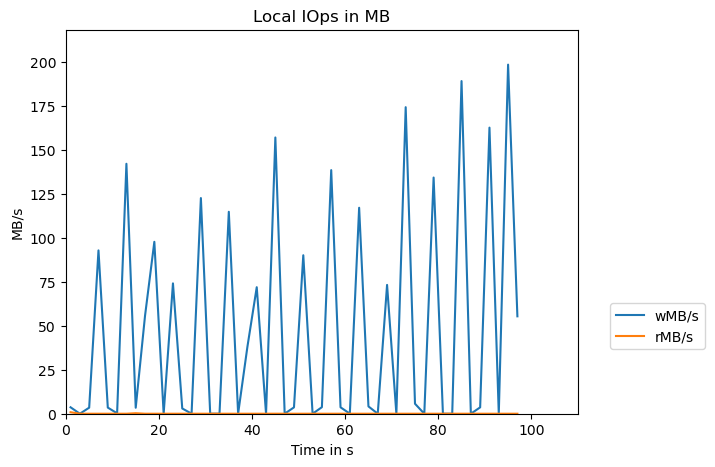

The local IO per second graph shows that the tiled write indeed produces a higher level of IOps to make the file write faster, but it is restricted by the speed of your SSD.

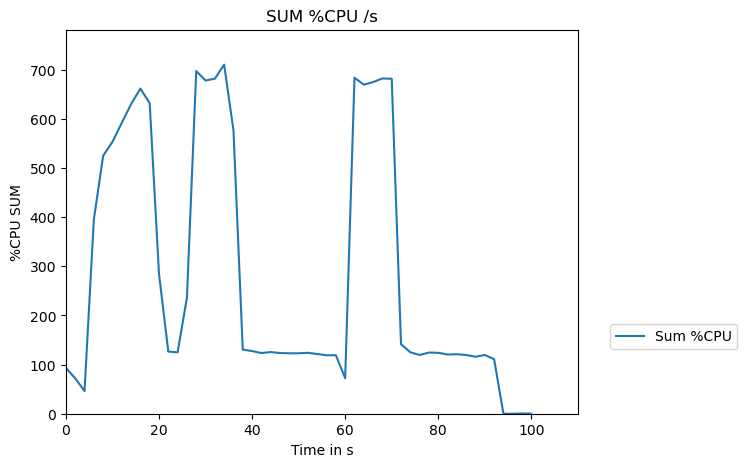

The CPU usage shows 2 peaks for the computing with dask, only 1 peak with the tiled write scenario

**Conclusion for Memory usage**

* Both method consumes the same amount of memory
* Cpu usage is higher with dask
* You must use the tiled write in order to gain time

## Conclusions and recommandations about parallel write

* Huge time gain without precision loss
* You have to carefully choose your chunk size using a multiple of the cog size

# Estimate the carbon impact of your code
Using code carbon you can have an estimate of your code footprint

In [6]:
from codecarbon import track_emissions


ModuleNotFoundError: No module named 'codecarbon'